(81, 31)


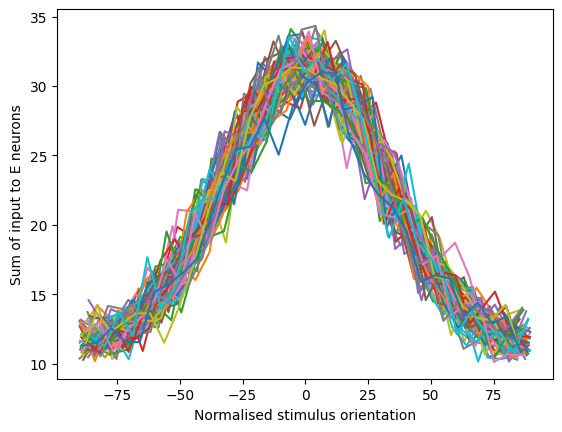

In [1]:
from importlib import reload
import os 
import jax
from model import middle_layer_fixed_point, obtain_fixed_point_centre_E
from SSN_classes_middle import SSN2DTopoV1_ONOFF_local
from SSN_classes_superficial import SSN2DTopoV1
from util import create_grating_single, take_log, init_set_func, load_param_from_csv, constant_to_vec
import matplotlib.pyplot as plt
from pdb import set_trace

import jax.numpy as np
import numpy
from analysis import full_width_half_max
from parameters import *

############################## PARAMETERS ############################

numpy.random.seed(1)

#Specify initialisation
init_set_m ='C'
init_set_s=1
J_2x2_s, s_2x2_s, gE_s, gI_s, conn_pars_s  = init_set_func(init_set_s, conn_pars_s, ssn_pars)
J_2x2_m, _, gE_m, gI_m, conn_pars_m  = init_set_func(init_set_m, conn_pars_m, ssn_pars, middle = True)

#Excitatory and inhibitory constants for extra synaptic GABA
c_E = 5.0
c_I = 5.0

#Feedforwards connections
f_E = 1.1
f_I = 0.7

sigma_oris = np.asarray([90.0, 90.0])
kappa_pre = np.asarray([0.0, 0.0])
kappa_post = np.asarray([0.0, 0.0])

#Generate trial data
ori_list = np.linspace(10, 180, 31)
all_data = []
stimuli_pars = StimuliPars()
for ori in ori_list:
    stimuli_pars.ref_ori = ori
    train_data = create_grating_single(stimuli_pars, n_trials = 1).squeeze()
    all_data.append(train_data)
all_data = np.vstack([all_data])

#Load orientation map
ssn_ori_map_loaded = np.load(os.path.join(os.getcwd(), 'orientation_maps', 'ssn_map_uniform_good.npy'))
trained_ori = 50

#Intialise SSNs 
ssn_mid=SSN2DTopoV1_ONOFF_local(ssn_pars=ssn_pars, grid_pars=grid_pars, conn_pars=conn_pars_m, filter_pars=filter_pars, J_2x2=J_2x2_m, gE = gE_m, gI=gI_m, ori_map = ssn_ori_map_loaded)
ssn_sup=SSN2DTopoV1(ssn_pars=ssn_pars, grid_pars=grid_pars, conn_pars=conn_pars_s,  J_2x2=J_2x2_s, s_2x2=s_2x2_s, sigma_oris = sigma_oris, kappa_pre = kappa_pre, kappa_post = kappa_post, ori_map = ssn_mid.ori_map, train_ori = trained_ori)
constant_vector = constant_to_vec(c_E, c_I, ssn=ssn_mid)
constant_vector_sup = constant_to_vec(c_E, c_I, ssn = ssn_sup, sup=True)
constant_vector_new = np.tile(constant_vector, (31,1)).T

output_ref = np.matmul(ssn_mid.gabor_filters, all_data.T)

SSN_input_ref = np.maximum(0, output_ref) + constant_vector_new
reshape_SSN = SSN_input_ref.reshape( 8, 81, -1)

E_SSN = np.stack([np.asarray(reshape_SSN[0, :, :]), np.asarray(reshape_SSN[2, :, :]), np.asarray(reshape_SSN[4, :, :]), np.asarray(reshape_SSN[6, :, :])])
ori_list = numpy.array(ori_list)
ori_map_vec = numpy.array(ssn_mid.ori_map.ravel())

inp = np.sqrt(np.sum(E_SSN**2, axis=0) )
print(inp.shape)
for i in range(0, 81):
    
    #Normalisation by subtracting
    #normalised_ori = ori_list - ori_map_vec[i]
    
    #Normalisation based on position
    normalised_ori = np.angle(np.exp( (ori_list - ori_map_vec[i] ) * 1j * 2 * np.pi / 180) )   * 180 / (2 * np.pi)
    
    #Sort values in same order as normalised orientations
    sorted_inp = inp[i,:][np.argsort(normalised_ori)]
    
    #plt.plot(normalised_ori, inp[i, :])
    plt.plot(np.sort(normalised_ori), sorted_inp)
    plt.xlabel('Normalised stimulus orientation')
    plt.ylabel('Sum of input to E neurons')
    #print(full_width_half_max(inp[i, :], normalised_ori[1] - normalised_ori[0]))


plt.savefig('/mnt/d/ABG_Projects_Backup/ssn_modelling/ssn-simulator/results/11-12/noise_'+str(stimuli_pars.std)+'gE'+str(gE_m)+'_f_E'+str(f_E)+'.png')
plt.show()

In [2]:
stimuli_pars.std

150.0

In [12]:
std = []
for i in output_ref:
    #print(i.max())
    std.append(i.mean())
print(np.asarray(std).mean())  

6.6227384e-09


0.0028682663


(array([  9.,  26.,  49.,  87., 152., 155.,  86.,  48.,  28.,   8.]),
 array([-14.02886105, -11.22308922,  -8.41731644,  -5.61154461,
         -2.8057723 ,   0.        ,   2.8057723 ,   5.61154461,
          8.41731644,  11.22308922,  14.02886105]),
 <BarContainer object of 10 artists>)

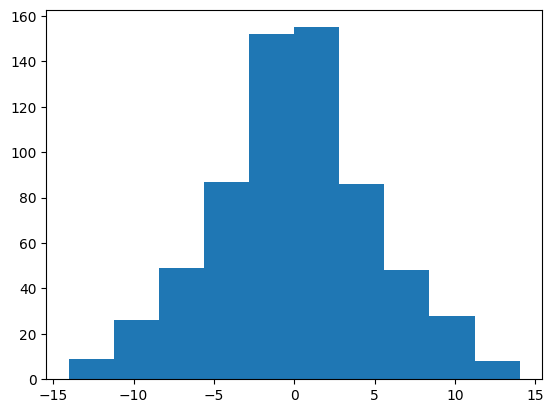

In [2]:
print(ssn_mid.A)
noise_0 = []
for i in range(0, ssn_mid.gabor_filters.shape[0]):
    noise_0.append(ssn_mid.gabor_filters[i].ravel() @ all_data[i])
    
plt.hist(np.asarray(noise_0))

0.0028682663


(array([ 15.,  27.,  44.,  84., 149., 155.,  76.,  51.,  28.,  19.]),
 array([-24.00665092, -19.25367737, -14.50070381,  -9.74773026,
         -4.9947567 ,  -0.24178314,   4.51119041,   9.26416397,
         14.01713753,  18.77011108,  23.52308464]),
 <BarContainer object of 10 artists>)

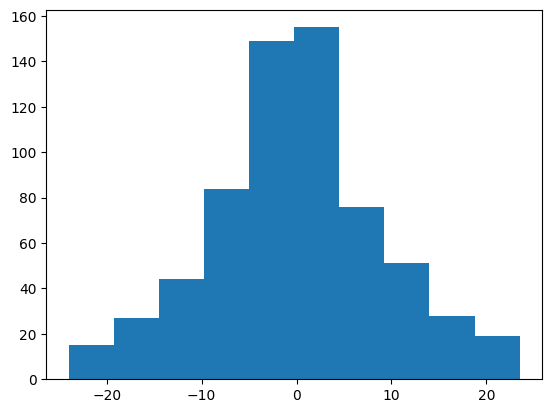

In [2]:
print(ssn_mid.A)
noise_0 = []
for i in range(0, ssn_mid.gabor_filters.shape[0]):
    noise_0.append(ssn_mid.gabor_filters[i].ravel() @ all_data[i])
    
plt.hist(np.asarray(noise_0))

In [3]:
0.011397778 / 0.0028682663

3.9737516701290954

0.011397778


(array([  9.,  27.,  48.,  87., 152., 155.,  86.,  47.,  29.,   8.]),
 array([-55.73970413, -44.59176254, -33.44382095, -22.29588127,
        -11.14794064,   0.        ,  11.14794064,  22.29588127,
         33.44382095,  44.59176254,  55.73970413]),
 <BarContainer object of 10 artists>)

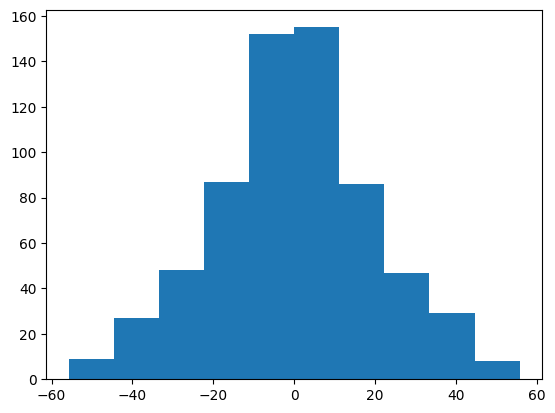

In [5]:
print(ssn_mid.A)
noise_40 = []
for i in range(0, ssn_mid.gabor_filters.shape[0]):
    noise_40.append(ssn_mid.gabor_filters[i].ravel() @ all_data[i])
    
plt.hist(np.asarray(noise_40))

In [9]:
ssn_mid.A

DeviceArray(0.00286827, dtype=float32)

In [8]:
for i in range(0, ssn_mid.gabor_filters.shape[0]):
    print(ssn_mid.gabor_filters[i].ravel() @ all_data[i])

-0.52746576
-7.7676663
2.9853
1.233372
10.310776
-7.684265
2.5804229
0.4253273
2.8070738
-20.722736
-5.7838078
-0.77174014
-5.924747
4.917479
7.458513
-1.3419166
3.44352
-14.960474
3.5271845
-0.98437047
4.197786
7.897376
-1.2000617
-4.0737767
-5.499548
14.253844
1.4775088
-21.198734
-1.1542156
16.564674
-23.040953
-4.282014
-1.3806202
-11.199711
-2.55799
-21.500303
-2.457599
1.2451533
1.7106514
-5.275544
3.2530446
-6.378929
1.2231076
1.8791986
-5.9377933
0.8302855
1.1318749
19.338009
-21.239937
-13.704723
-22.23852
9.540397
-16.668163
-21.606134
-10.346888
-0.9527083
-22.54841
1.8723292
11.365797
5.8736453
9.654321
-10.841043
-0.26397705
-5.51865
8.213674
7.279424
-7.6169896
-0.92199415
-13.244521
-10.015712
16.280296
2.3544676
-2.2307649
-2.0365293
-2.122186
11.544951
3.5782347
-0.77158445
-0.96828324
-9.340773
-6.794343
-1.3108344
12.04038
-13.629496
0.31128758
20.005535
-0.93771994
-14.479168
-19.601461
-1.5926697
0.70313543
0.45223945
-16.041924
6.234951
6.030108
1.2960591
7.197401

In [4]:
(ssn_mid.gabor_filters @ all_data).shape

TypeError: dot_general requires contracting dimensions to have the same shape, got (16641,) and (31,).

(array([ 27073.,  28520.,  32044.,  32494.,  54839., 222437.,  31707.,
         30023.,  29748.,  26986.]),
 array([  0. ,  76.5, 153. , 229.5, 306. , 382.5, 459. , 535.5, 612. ,
        688.5, 765. ]),
 <BarContainer object of 10 artists>)

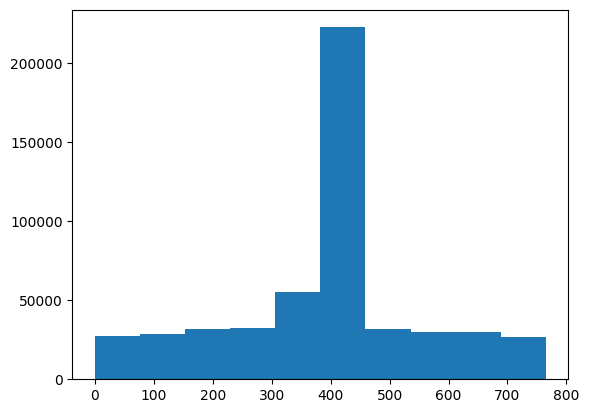

In [4]:
plt.hist(all_data.ravel())

In [8]:
ssn_mid.A2

DeviceArray(-0.01149443, dtype=float32)

In [9]:
ssn_mid.A

DeviceArray(0.01139778, dtype=float32)

In [12]:
no_noise_data = []
for ori in ori_list:
    stimuli_pars.ref_ori = ori
    stimuli_pars.std = 0.0
    train_data = create_grating_single(stimuli_pars, n_trials = 1).squeeze()
    no_noise_data.append(train_data)
no_noise_data = np.vstack([no_noise_data])

In [2]:
ori_list = np.linspace(10, 180, 100)
all_data = []
for ori in ori_list:
    stimuli_pars.ref_ori = ori
    train_data = create_grating_single(stimuli_pars, n_trials = 1).squeeze()
    all_data.append(train_data)
all_data = np.vstack([all_data])

#Intialise SSNs 
# ssn_mid=SSN2DTopoV1_ONOFF_local(ssn_pars=ssn_pars, grid_pars=grid_pars, conn_pars=conn_pars_m, filter_pars=filter_pars, J_2x2=J_2x2_m, gE = gE_m, gI=gI_m, ori_map = ssn_ori_map_loaded)

output_ref = np.matmul(ssn_mid.gabor_filters, all_data.T)

SSN_input_ref = np.maximum(0, output_ref)  + np.tile(constant_vector, (100,1)).T
reshape_SSN = SSN_input_ref.reshape( 8, 81, -1)

E_SSN = reshape_SSN[0:9:2]
inp = np.sqrt(np.sum(E_SSN**2, axis=0) )


ori_list = numpy.array(ori_list)
ori_map_vec = numpy.array(ssn_mid.ori_map.ravel())



In [3]:
SSN_input_ref_no_rect = np.maximum(0, output_ref)
reshape_SSN_no_rect = SSN_input_ref_no_rect.reshape(8, 81, -1)
E_SSN_norect = reshape_SSN_no_rect[0:9:2]
inp_norect = np.sqrt(np.sum(E_SSN_norect**2, axis=0) )


765.0 0.0015418482


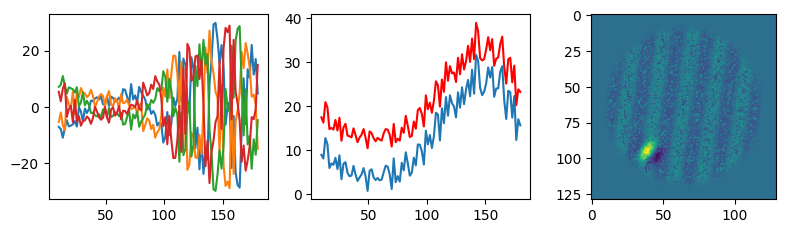

In [4]:
ph = 1
gr = 1

n_ori = len(ori_list)
reshape_SSN1 = output_ref.reshape( 8, 81, -1)
gabors = ssn_mid.gabor_filters.reshape(8, 81, 129, 129)
gratings = all_data.reshape(n_ori, 129, 129)


fig, axs = plt.subplots(1,3, figsize=np.array([6.4*3, 4.8])/2)
# axs[0].plot(ori_list, reshape_SSN1[2*ph,gr,:])
axs[0].plot(ori_list, reshape_SSN1[::2,gr,:].T)
#axs[1].imshow(gabors[2*ph, gr])
axs[1].plot(ori_list, inp_norect[gr,:])
axs[1].plot(ori_list, inp[gr,:], 'r')
axs[2].imshow(gratings[-6] + 1e6 * gabors[2*ph, gr])
print(gratings[-6].max(), gabors[2*ph, gr].max())

#ncols = int(np.sqrt(n_ori))
#nrows = 1 + n_ori // ncols
#fig, axs = plt.subplots(nrows, ncols, figsize=np.array([6.4, 6.4]))
#for ii, grat in enumerate(gratings):
#    col = ii % ncols
#    row = ii // ncols
#    axs[row, col].imshow(grat)
plt.savefig(os.path.join(os.getcwd(), 'results', '04-12', 'noise_'+str(stimuli_pars.std)+'gabor_plots_gE'+str(gE_m)+'_f_E'+str(f_E)+'.png'))

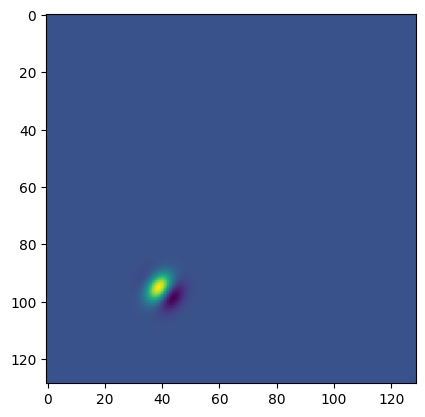

In [4]:
plt.imshow(gabors[2*ph, gr])